In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import re
import warnings
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
warnings.filterwarnings('ignore')

In [2]:
# Import dataset with Pandas 
dataset = pd.read_csv("train.csv", error_bad_lines=False, encoding="utf-8")
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
dataset.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [5]:
# Missing values
(dataset.isnull().sum()/len(dataset))*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

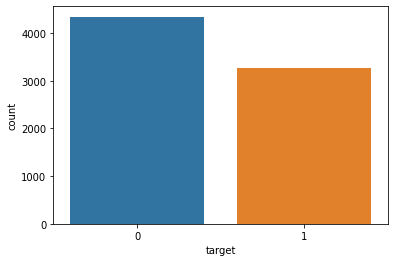

In [6]:
sns.countplot(x = dataset["target"])

In [7]:
#We keep only useful info
dataset = dataset[['text','target']]
dataset.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
!python -m spacy download en_core_web_sm -q

2022-11-01 19:58:32.014429: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 12.8 MB 8.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
# Import Spacy and english initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()

# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

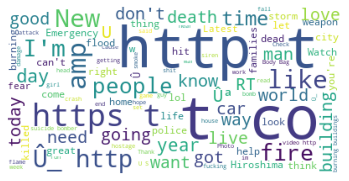

In [10]:
#Wordcloud
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px

# Stripped corpus of text
stripped_corpus = [text.strip() for text in dataset["text"]]
# Join corpus to make one full string
full_corpus = " ".join(stripped_corpus)

corpus = nlp(full_corpus)

# Instanciate WordCloud 
wordcloud = WordCloud(background_color = 'white', stopwords = STOP_WORDS, max_words = 100).generate(corpus.text)

# Show word cloud with matplotlib 
plt.imshow(wordcloud)

# Remove trailing logs
plt.axis("off") 
plt.show()

**Preprocessing**

In [11]:
#Text cleaning

dataset["text_clean"] = dataset["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: re.split('http:\/\/.*', str(x))[0])
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

dataset.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...


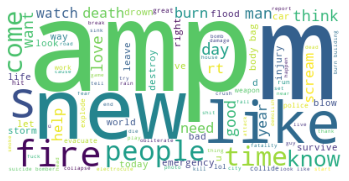

In [12]:
#Global Wordcloud with cleaned text
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px

# Stripped corpus of text
stripped_corpus = [text.strip() for text in dataset["text_clean"]]
# Join corpus to make one full string
full_corpus = " ".join(stripped_corpus)

corpus = nlp(full_corpus)

# Instanciate WordCloud 
wordcloud = WordCloud(background_color = 'white', stopwords = STOP_WORDS, max_words = 100).generate(corpus.text)

# Show word cloud with matplotlib 
plt.imshow(wordcloud)

# Remove trailing logs
plt.axis("off") 
plt.show()

In [13]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(dataset["text_clean"])
dataset["text_encoded"] = tokenizer.texts_to_sequences(dataset.text_clean)
dataset["len_tweet"] = dataset["text_encoded"].apply(lambda x: len(x))
dataset = dataset[dataset["len_tweet"]!=0]

dataset.head()

,text,target,text_clean,text_encoded,len_tweet
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[412, 172]",2
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[118, 3, 161, 511]",4
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[444, 323, 292, 187, 323, 280, 379]",7
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[7, 68, 187, 280, 35]",5
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[258, 180, 122, 173, 68, 111]",6


In [14]:
#Padding
maxlen = max(dataset['text_encoded'].apply(lambda x : len(x)))
tweets_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.text_encoded, padding="post", maxlen=maxlen)
full_ds = tf.data.Dataset.from_tensor_slices((tweets_pad, dataset.target))

In [15]:
# Train Test Split
TAKE_SIZE = int(0.7*dataset.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [16]:
#Let's check a batch 
for tweet, target in train_data.take(1):
  print(tweet, target)

tf.Tensor(
[[792 243  22 ...   0   0   0]
 [ 16 354   0 ...   0   0   0]
 [ 13  73   0 ...   0   0   0]
 ...
 [ 28 421 140 ...   0   0   0]
 [  2 150   0 ...   0   0   0]
 [477  10  56 ...   0   0   0]], shape=(64, 18), dtype=int32) tf.Tensor(
[1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0], shape=(64,), dtype=int64)


**Modeling**

In [17]:
vocab_size = len(tokenizer.word_index)
emb_dim=64

model_emb = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, emb_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [18]:
model_emb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 64)            1304320   
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,305,505
Trainable params: 1,305,505
Non-trainable params: 0
______________________________________________

In [19]:
#we optimize the model with Adam optimizer
optimizer= tf.keras.optimizers.Adam()
#we have a binary classification problem hence the metrics chosen below 
model_emb.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [20]:
history_emb = model_emb.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data)

Epoch 1/20
83/83 [==============================] - 3s 21ms/step - loss: 0.6885 - accuracy: 0.5933 - val_loss: 0.6820 - val_accuracy: 0.6353
Epoch 2/20
83/83 [==============================] - 1s 16ms/step - loss: 0.6456 - accuracy: 0.7506 - val_loss: 0.6031 - val_accuracy: 0.7589
Epoch 3/20
83/83 [==============================] - 1s 18ms/step - loss: 0.5090 - accuracy: 0.8104 - val_loss: 0.4995 - val_accuracy: 0.7638
Epoch 4/20
83/83 [==============================] - 1s 18ms/step - loss: 0.4209 - accuracy: 0.8232 - val_loss: 0.4907 - val_accuracy: 0.7567
Epoch 5/20
83/83 [==============================] - 1s 17ms/step - loss: 0.3912 - accuracy: 0.8348 - val_loss: 0.4958 - val_accuracy: 0.7558
Epoch 6/20
83/83 [==============================] - 1s 17ms/step - loss: 0.3758 - accuracy: 0.8405 - val_loss: 0.5054 - val_accuracy: 0.7576
Epoch 7/20
83/83 [==============================] - 1s 18ms/step - loss: 0.3699 - accuracy: 0.8471 - val_loss: 0.5204 - val_accuracy: 0.7514
Epoch 8/20
83

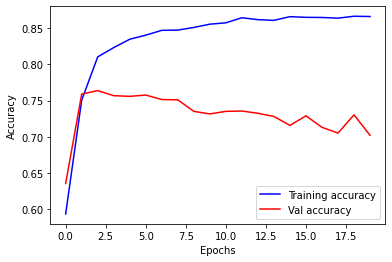

In [21]:
import matplotlib.pyplot as plt

#Train & Val Accuracy vs EPOCHS
plt.plot(history_emb.history["accuracy"], color="b", label='Training accuracy')
plt.plot(history_emb.history["val_accuracy"], color="r", label='Val accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

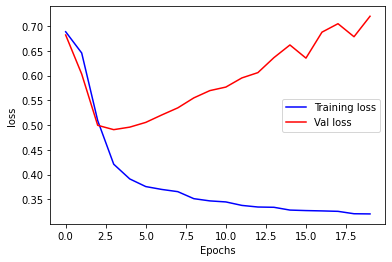

In [22]:
#Train & Val Loss vs EPOCHS
plt.plot(history_emb.history["loss"], color="b",label='Training loss')
plt.plot(history_emb.history["val_loss"], color="r",label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [23]:
model_emb.save("model_emb.h5")

**SimpleRNN**

In [24]:
#vocab_size = len(tokenizer_train.word_index)
model_SRNN = tf.keras.Sequential([
                  # Word Embedding layer           
                  tf.keras.layers.Embedding(vocab_size+1, emb_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.SimpleRNN(units=32, return_sequences=True), # maintains the sequential nature
                  tf.keras.layers.SimpleRNN(units=16, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),
                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [25]:
model_SRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 64)            1304320   
                                                                 
 simple_rnn (SimpleRNN)      (None, 18, 32)            3104      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,308,625
Trainable params: 1,308,625
No

In [26]:
optimizer= tf.keras.optimizers.Adam()

model_SRNN.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

In [27]:

history_SRNN = model_SRNN.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data)

Epoch 1/20
83/83 [==============================] - 5s 33ms/step - loss: 0.6109 - accuracy: 0.6514 - val_loss: 0.5914 - val_accuracy: 0.7373
Epoch 2/20
83/83 [==============================] - 2s 26ms/step - loss: 0.4564 - accuracy: 0.8011 - val_loss: 0.5790 - val_accuracy: 0.7351
Epoch 3/20
83/83 [==============================] - 2s 28ms/step - loss: 0.3828 - accuracy: 0.8442 - val_loss: 0.5995 - val_accuracy: 0.7210
Epoch 4/20
83/83 [==============================] - 2s 28ms/step - loss: 0.3194 - accuracy: 0.8781 - val_loss: 0.5946 - val_accuracy: 0.7347
Epoch 5/20
83/83 [==============================] - 3s 39ms/step - loss: 0.2821 - accuracy: 0.8919 - val_loss: 0.7064 - val_accuracy: 0.6980
Epoch 6/20
83/83 [==============================] - 4s 49ms/step - loss: 0.2441 - accuracy: 0.9118 - val_loss: 0.7543 - val_accuracy: 0.7170
Epoch 7/20
83/83 [==============================] - 4s 53ms/step - loss: 0.2238 - accuracy: 0.9201 - val_loss: 0.7782 - val_accuracy: 0.6985
Epoch 8/20
83

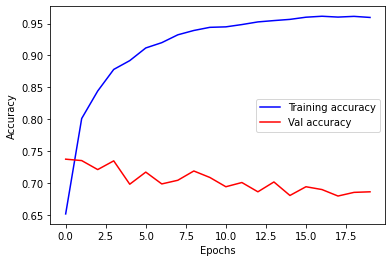

In [28]:
#Train & Val Accuracy vs EPOCHS
plt.plot(history_SRNN.history["accuracy"], color="b",label='Training accuracy')
plt.plot(history_SRNN.history["val_accuracy"], color="r",label='Val accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

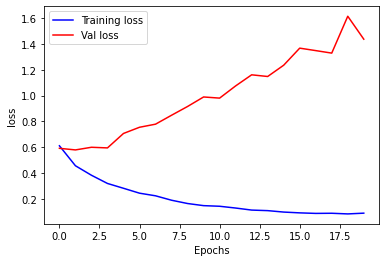

In [29]:
#Train & Val Loss vs EPOCHS 
plt.plot(history_SRNN.history["loss"], color="b",label='Training loss')
plt.plot(history_SRNN.history["val_loss"], color="r",label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [30]:
model_SRNN.save("model_SRNN.h5")

**GRU**

In [31]:
vocab_size = len(tokenizer.word_index)
model_GRU = tf.keras.Sequential([
                  Embedding(vocab_size+1, emb_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  Dense(5, activation="sigmoid")
])

In [32]:
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 64)            1304320   
                                                                 
 gru (GRU)                   (None, 18, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 5)                 45        
                                                                 
Total params: 1,339,397
Trainable params: 1,339,397
No

In [33]:
optimizer= tf.keras.optimizers.Adam()

model_GRU.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [34]:
history_GRU = model_GRU.fit(train_data,
              epochs=20, 
              validation_data=test_data)

Epoch 1/20
83/83 [==============================] - 10s 65ms/step - loss: 0.8289 - accuracy: 0.5804 - val_loss: 0.6696 - val_accuracy: 0.5766
Epoch 2/20
83/83 [==============================] - 4s 48ms/step - loss: 0.6005 - accuracy: 0.7084 - val_loss: 0.5412 - val_accuracy: 0.7364
Epoch 3/20
83/83 [==============================] - 4s 43ms/step - loss: 0.4516 - accuracy: 0.8075 - val_loss: 0.5173 - val_accuracy: 0.7510
Epoch 4/20
83/83 [==============================] - 4s 43ms/step - loss: 0.4066 - accuracy: 0.8369 - val_loss: 0.5389 - val_accuracy: 0.7488
Epoch 5/20
83/83 [==============================] - 4s 44ms/step - loss: 0.3780 - accuracy: 0.8514 - val_loss: 0.5570 - val_accuracy: 0.7325
Epoch 6/20
83/83 [==============================] - 4s 45ms/step - loss: 0.3598 - accuracy: 0.8617 - val_loss: 0.5783 - val_accuracy: 0.7289
Epoch 7/20
83/83 [==============================] - 4s 44ms/step - loss: 0.3463 - accuracy: 0.8702 - val_loss: 0.5741 - val_accuracy: 0.7360
Epoch 8/20
8

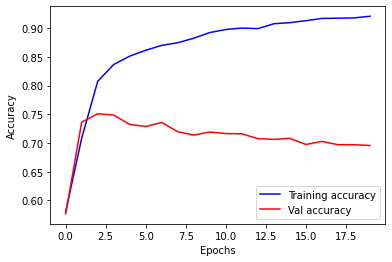

In [35]:
#Train & Val Accuracy vs EPOCHS
plt.plot(history_GRU.history["accuracy"], color="b", label='Training accuracy')
plt.plot(history_GRU.history["val_accuracy"], color="r", label='Val accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

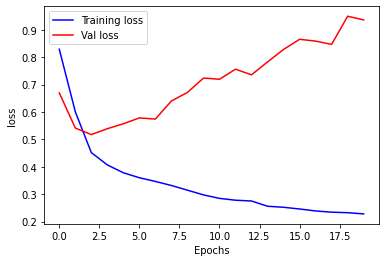

In [36]:
#Train & Val Loss vs EPOCHS
plt.plot(history_GRU.history["loss"], color="b",label='Training loss')
plt.plot(history_GRU.history["val_loss"], color="r",label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [37]:
model_GRU.save("model_GRU.h5")

**LSTM**

In [38]:
model_lstm = tf.keras.Sequential([
                  tf.keras.layers.Embedding(vocab_size+1, emb_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  tf.keras.layers.LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  tf.keras.layers.LSTM(units=32, return_sequences=False), # returns the last output
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [39]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 64)            1304320   
                                                                 
 lstm (LSTM)                 (None, 18, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,350,433
Trainable params: 1,350,433
No

In [40]:
optimizer= tf.keras.optimizers.Adam()

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [41]:
history_lstm = model_lstm.fit(train_data, 
               epochs=20,
               validation_data=test_data)

Epoch 1/20
83/83 [==============================] - 9s 57ms/step - loss: 0.5888 - accuracy: 0.6762 - val_loss: 0.5003 - val_accuracy: 0.7687
Epoch 2/20
83/83 [==============================] - 4s 46ms/step - loss: 0.4274 - accuracy: 0.8160 - val_loss: 0.5009 - val_accuracy: 0.7598
Epoch 3/20
83/83 [==============================] - 5s 61ms/step - loss: 0.3965 - accuracy: 0.8354 - val_loss: 0.5929 - val_accuracy: 0.7232
Epoch 4/20
83/83 [==============================] - 4s 45ms/step - loss: 0.3834 - accuracy: 0.8420 - val_loss: 0.5477 - val_accuracy: 0.7298
Epoch 5/20
83/83 [==============================] - 4s 45ms/step - loss: 0.3667 - accuracy: 0.8520 - val_loss: 0.5966 - val_accuracy: 0.7121
Epoch 6/20
83/83 [==============================] - 4s 44ms/step - loss: 0.3622 - accuracy: 0.8530 - val_loss: 0.5896 - val_accuracy: 0.7135
Epoch 7/20
83/83 [==============================] - 4s 44ms/step - loss: 0.3576 - accuracy: 0.8575 - val_loss: 0.6091 - val_accuracy: 0.6945
Epoch 8/20
83

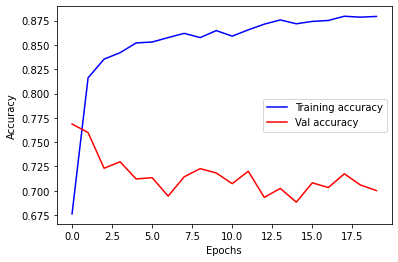

In [42]:
#Train & Val Accuracy vs EPOCHS
plt.plot(history_lstm.history["accuracy"], color="b",label='Training accuracy')
plt.plot(history_lstm.history["val_accuracy"], color="r",label='Val accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

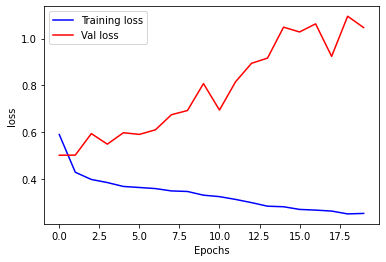

In [43]:
#Train & Val Loss vs EPOCHS 
plt.plot(history_lstm.history["loss"], color="b",label='Training loss')
plt.plot(history_lstm.history["val_loss"], color="r",label='Val loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [44]:
model_lstm.save("model_LSTM.h5")

**Prediction**

In [45]:
df_tweets = pd.read_csv("test.csv")

In [46]:
df_tweets = df_tweets.loc[:,['id','text']]
df_tweets["text_clean"] = df_tweets["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df_tweets["text_clean"] = df_tweets["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_tweets["text_clean"] = df_tweets["text_clean"].apply(lambda x: re.split('http:\/\/.*', str(x))[0])
df_tweets["text_clean"] = df_tweets["text_clean"].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df_tweets["text_clean"] = df_tweets["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

tokenizer.fit_on_texts(df_tweets.text_clean)
df_tweets["text_encoded"] = tokenizer.texts_to_sequences(df_tweets.text_clean)
tweets_test_pad = tf.keras.preprocessing.sequence.pad_sequences(df_tweets.text_encoded, padding="post", maxlen=maxlen)

df_tweets.head()

,id,text,text_clean,text_encoded
0,0,Just happened a terrible car crash,happen terrible car crash,"[148, 47, 15]"
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[100, 181, 128, 397, 998]"
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[95, 2, 556, 361, 98]"
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[292, 75]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[387, 589, 10, 314]"


In [47]:
vocab_size = len(tokenizer.word_index)
model_final = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, emb_dim, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])


In [48]:

optimizer= tf.keras.optimizers.Adam()

model_final.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [49]:
history_final = model_final.fit(train_data, 
                    epochs=4, 
                    validation_data=test_data)

Epoch 1/4
83/83 [==============================] - 3s 24ms/step - loss: 0.6710 - accuracy: 0.5746 - val_loss: 0.6608 - val_accuracy: 0.5691
Epoch 2/4
83/83 [==============================] - 2s 22ms/step - loss: 0.5833 - accuracy: 0.7097 - val_loss: 0.5460 - val_accuracy: 0.7594
Epoch 3/4
83/83 [==============================] - 2s 20ms/step - loss: 0.4425 - accuracy: 0.8068 - val_loss: 0.4935 - val_accuracy: 0.7634
Epoch 4/4
83/83 [==============================] - 2s 22ms/step - loss: 0.4006 - accuracy: 0.8259 - val_loss: 0.5049 - val_accuracy: 0.7488


In [50]:
model_final.save("model_final.h5")

In [51]:
predict = model_final.predict(tweets_test_pad)
df_tweets['predicted_real'] = predict
df_tweets['predicted_binary'] = round(df_tweets['predicted_real'])
df_tweets['target'] = df_tweets['predicted_binary'].astype('int')

102/102 [==============================] - 0s 1ms/step


In [52]:
df_tweets = df_tweets.drop(columns=['text_clean','text_encoded','predicted_real','predicted_binary','text'])


In [53]:
df_tweets.to_csv('sample_submission_final.csv', index=False)